In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score,explained_variance_score
from scipy.stats import chi2_contingency
import lightgbm as lgb
from itertools import combinations 
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white,het_breuschpagan
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('/kaggle/input/india-agriculture-crop-production/India Agriculture Crop Production.csv')

In [3]:
df.head()
#The Yield column is calculated as (Production / Area)

,State,District,Crop,Year,Season,Area,Area Units,Production,Production Units,Yield
0,Andaman and Nicobar Islands,NICOBARS,Arecanut,2001-02,Kharif,1254.0,Hectare,2061.0,Tonnes,1.643541
1,Andaman and Nicobar Islands,NICOBARS,Arecanut,2002-03,Whole Year,1258.0,Hectare,2083.0,Tonnes,1.655803
2,Andaman and Nicobar Islands,NICOBARS,Arecanut,2003-04,Whole Year,1261.0,Hectare,1525.0,Tonnes,1.209358
3,Andaman and Nicobar Islands,NORTH AND MIDDLE ANDAMAN,Arecanut,2001-02,Kharif,3100.0,Hectare,5239.0,Tonnes,1.690000
4,Andaman and Nicobar Islands,SOUTH ANDAMANS,Arecanut,2002-03,Whole Year,3105.0,Hectare,5267.0,Tonnes,1.696296


In [4]:
#I will take the starting season of all of them.
print(df['Year'].value_counts())

Year
2019-20    19296
2018-19    18302
2017-18    18008
2016-17    17418
2015-16    16339
2013-14    16178
2011-12    16132
2014-15    15587
2009-10    15341
2012-13    15279
2008-09    15150
2010-11    14889
2007-08    14681
2006-07    14678
2003-04    14662
2002-03    14182
2004-05    14151
2005-06    14063
2000-01    13593
2001-02    13307
1999-00    13013
1998-99    12290
1997-98     8549
2020-21      319
Name: count, dtype: int64


In [5]:
df['Year'] = df['Year'].str[:4].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345407 entries, 0 to 345406
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   State             345407 non-null  object 
 1   District          345407 non-null  object 
 2   Crop              345375 non-null  object 
 3   Year              345407 non-null  int64  
 4   Season            345406 non-null  object 
 5   Area              345374 non-null  float64
 6   Area Units        345407 non-null  object 
 7   Production        340414 non-null  float64
 8   Production Units  345407 non-null  object 
 9   Yield             345374 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 26.4+ MB


In [6]:
#I deleted most of the null values because they were in the value we were going to predict.
df = df.dropna()
df['Area Units'].value_counts().sort_values()

Area Units
Hectare    340414
Name: count, dtype: int64

In [7]:
#I am deleting this column because everything is in hectares
df = df.drop('Area Units',axis = 1)
df.head()

,State,District,Crop,Year,Season,Area,Production,Production Units,Yield
0,Andaman and Nicobar Islands,NICOBARS,Arecanut,2001,Kharif,1254.0,2061.0,Tonnes,1.643541
1,Andaman and Nicobar Islands,NICOBARS,Arecanut,2002,Whole Year,1258.0,2083.0,Tonnes,1.655803
2,Andaman and Nicobar Islands,NICOBARS,Arecanut,2003,Whole Year,1261.0,1525.0,Tonnes,1.209358
3,Andaman and Nicobar Islands,NORTH AND MIDDLE ANDAMAN,Arecanut,2001,Kharif,3100.0,5239.0,Tonnes,1.690000
4,Andaman and Nicobar Islands,SOUTH ANDAMANS,Arecanut,2002,Whole Year,3105.0,5267.0,Tonnes,1.696296


In [8]:
#Since the weights in bales and coconuts are very few, I will convert them all to tons
print(df['Production Units'].value_counts().sort_values())

Production Units
Nuts        2891
Bales      10524
Tonnes    326999
Name: count, dtype: int64


In [9]:
print(df[df['Production Units'] == 'Bales']['Crop'].value_counts().sort_values())
print('\n',df[df['Production Units'] == 'Nuts']['Crop'].value_counts().sort_values())

Crop
Jute            1837
Mesta           2369
Cotton(lint)    6318
Name: count, dtype: int64

 Crop
Coconut    2891
Name: count, dtype: int64


In [10]:
#I will convert the weight of each product separately into tons
df.loc[df['Crop'] == 'Cotton(lint)','Production'] = (df.loc[df['Crop'] == 'Cotton(lint)','Production']*170)/1000
df.loc[df['Crop'] == 'Jute','Production'] = (df.loc[df['Crop'] == 'Jute','Production']*180)/1000
df.loc[df['Crop'] == 'Mesta','Production'] = (df.loc[df['Crop'] == 'Mesta','Production']*180)/1000
df.loc[df['Crop'] == 'Coconut','Production'] = (df.loc[df['Crop'] == 'Coconut','Production']*1.5)/1000
df = df.drop('Production Units',axis = 1)
df.head()

,State,District,Crop,Year,Season,Area,Production,Yield
0,Andaman and Nicobar Islands,NICOBARS,Arecanut,2001,Kharif,1254.0,2061.0,1.643541
1,Andaman and Nicobar Islands,NICOBARS,Arecanut,2002,Whole Year,1258.0,2083.0,1.655803
2,Andaman and Nicobar Islands,NICOBARS,Arecanut,2003,Whole Year,1261.0,1525.0,1.209358
3,Andaman and Nicobar Islands,NORTH AND MIDDLE ANDAMAN,Arecanut,2001,Kharif,3100.0,5239.0,1.690000
4,Andaman and Nicobar Islands,SOUTH ANDAMANS,Arecanut,2002,Whole Year,3105.0,5267.0,1.696296


In [11]:
#Since we are performing direct operations on Production here, we will need to recalculate the Yield as well
df = df.drop('Yield',axis = 1)
df['Yield'] = df['Production'] / df['Area']

In [12]:
#I will group some crops with a small number of occurrences as "Other"
print(df['Crop'].value_counts().sort_values())

Crop
Dry Ginger                   3
Other Summer Pulses         66
Cardamom                   483
Oilseeds total             702
other oilseeds            1190
Moth                      1287
Other Cereals             1338
Black pepper              1370
Cashewnut                 1519
Cowpea(Lobia)             1697
Safflower                 1727
Khesari                   1753
Jute                      1837
Guar seed                 2045
Arecanut                  2150
Tapioca                   2264
Mesta                     2369
Niger seed                2707
Sannhamp                  2738
Coconut                   2891
Tobacco                   3513
Banana                    4393
Castor seed               4496
Ginger                    4652
Other Rabi pulses         4728
Soyabean                  4953
Coriander                 4954
Garlic                    4958
Horse-gram                5294
Other Kharif pulses       5590
Sweet potato              5656
Ragi                      5725
Lin

In [13]:
#I will group some states with a small number of occurrences as "Other"
print(df['State'].value_counts().sort_values())
len(df['State'].value_counts().sort_values())

State
Laddakh                            1
Daman and Diu                     42
Chandigarh                       123
Delhi                            203
Dadra and Nagar Haveli           329
Goa                              398
Andaman and Nicobar Islands      725
Sikkim                           876
Puducherry                      1123
Mizoram                         2108
Tripura                         2557
Manipur                         3092
Punjab                          4098
Meghalaya                       4322
Jammu and Kashmir               4342
Arunachal Pradesh               4344
Kerala                          4642
Telangana                       4662
Himachal Pradesh                4974
Jharkhand                       4991
Nagaland                        5674
Uttarakhand                     6628
Haryana                         6931
West Bengal                    12580
Gujarat                        13968
Chhattisgarh                   14732
Odisha                         1

36

In [14]:
#I will group some districts with a small number of occurrences as "Other"
print(df['District'].value_counts().sort_values())

District
MUMBAI                        1
SOUTH SALMARA MANCACHAR       1
CHENNAI                       1
MAJULI                        2
MUMBAI SUBURBAN               2
                           ... 
HAVERI                     1142
DAVANGERE                  1142
AURANGABAD                 1151
BIJAPUR                    1165
BILASPUR                   1214
Name: count, Length: 728, dtype: int64


In [15]:
#Since each season appears frequently enough here, grouping them as "Other" is not reasonable
print(df['Season'].value_counts().sort_values())

Season
Autumn          6967
Winter          8238
Summer         21974
Whole Year     67265
Rabi           99805
Kharif        136165
Name: count, dtype: int64


In [16]:
#I am looking at the relationships between numeric features.
print(df[['Production', 'Yield', 'Year', 'Area']].corr())
#I will remove the Year feature because it has very little effect on Production

            Production     Yield      Year      Area
Production    1.000000  0.180433  0.003618  0.256061
Yield         0.180433  1.000000  0.016501 -0.008963
Year          0.003618  0.016501  1.000000 -0.024091
Area          0.256061 -0.008963 -0.024091  1.000000


In [17]:
#I am looking at the eta coefficient between Production and categorical features.

columns = ['State','District','Crop','Season']
for i in columns:
    
    kategoriler = df[i].unique() 
    production_ort = df['Production'].mean()
    toplam = 0
    for j in df['Production']:
        toplam += (j-production_ort)**2
    top_varyans = toplam / (len(df['Production'])-1)

    grup_ort = df.groupby(i)['Production'].mean()
    toplam2 = 0
    for isim,ort in grup_ort.items():
        kategorik_adedi = len(df[df[i] == isim])
        toplam2 += ((ort-production_ort)**2)*kategorik_adedi
    gruplar_varyans = toplam2/((len(df)-len(grup_ort)))
    print(f'Production & {i}: {(gruplar_varyans/top_varyans)**0.5}')

Production & State: 0.09533607892287271
Production & District: 0.18174436633531332
Production & Crop: 0.3181276238558495
Production & Season: 0.06659807270315289


In [18]:
#I am looking at the Cramér's V coefficient between categorical features.

column_pairs = [
    ('State', 'District'),
    ('State', 'Crop'),
    ('District', 'Crop'),
    ('Season', 'Crop'),
    ('Season', 'District'),
    ('Season', 'State')
]
for col1, col2 in column_pairs:
    kontenjans = pd.crosstab(df[col1], df[col2])
    ki_kare, p, sd, beklenen = chi2_contingency(kontenjans)
    beklenen = np.round(beklenen, 2)
    
    k = len(kontenjans.columns)  
    r = len(kontenjans.index)
    v = (ki_kare / ((len(df) * min(k-1, r-1)))) ** 0.5
    print(f'{col1} ile {col2} arasındaki ilişki: {v}')
    
#There is a very strong relationship between State and District, so we need to remove one of them from the data.

State ile District arasındaki ilişki: 0.9703714218392978
State ile Crop arasındaki ilişki: 0.14601117583157236
District ile Crop arasındaki ilişki: 0.13804650894154016
Season ile Crop arasındaki ilişki: 0.5200700538708223
Season ile District arasındaki ilişki: 0.31499231625480767
Season ile State arasındaki ilişki: 0.30830998159024825


In [19]:
#I looked at the eta coefficient between Area and categorical data.

columns = ['State','District','Crop','Season']
for i in columns:
    
    kategoriler = df[i].unique() 
    numeric_ort = df['Area'].mean()
    toplam = 0
    for j in df['Area']:
        toplam += (j-numeric_ort)**2
    top_varyans = toplam / (len(df['Area'])-1)

    grup_ort = df.groupby(i)['Area'].mean()
    toplam2 = 0
    for isim,ort in grup_ort.items():
        kategorik_adedi = len(df[df[i] == isim])
        toplam2 += ((ort-numeric_ort)**2)*kategorik_adedi
    gruplar_varyans = toplam2/((len(df)-len(grup_ort)))
    print(f'Area & {i}: {(gruplar_varyans/top_varyans)**0.5}')

#There is no problem because the relationship coefficients are low.

Area & State: 0.1623243159105378
Area & District: 0.21794460690260903
Area & Crop: 0.33858435977117124
Area & Season: 0.11824085193321014


In [20]:
#I looked at the eta coefficient between Yield and categorical data

columns = ['State','District','Crop','Season']
for i in columns:
    
    kategoriler = df[i].unique() 
    numeric_ort = df['Yield'].mean()
    toplam = 0
    for j in df['Yield']:
        toplam += (j-numeric_ort)**2
    top_varyans = toplam / (len(df['Yield'])-1)

    grup_ort = df.groupby(i)['Yield'].mean()
    toplam2 = 0
    for isim,ort in grup_ort.items():
        kategorik_adedi = len(df[df[i] == isim])
        toplam2 += ((ort-numeric_ort)**2)*kategorik_adedi
    gruplar_varyans = toplam2/((len(df)-len(grup_ort)))
    print(f'Yield & {i}: {(gruplar_varyans/top_varyans)**0.5}')
#There is no problem because the relationship coefficients are low.

Yield & State: 0.07614028105868537
Yield & District: 0.0934536454096852
Yield & Crop: 0.44644291470620623
Yield & Season: 0.1931220636638574


In [21]:
#I looked at the eta coefficient between Year and categorical data.

columns = ['State','District','Crop','Season']
for i in columns:
    
    kategoriler = df[i].unique() 
    numeric_ort = df['Year'].mean()
    toplam = 0
    for j in df['Year']:
        toplam += (j-numeric_ort)**2
    top_varyans = toplam / (len(df['Year'])-1)

    grup_ort = df.groupby(i)['Year'].mean()
    toplam2 = 0
    for isim,ort in grup_ort.items():
        kategorik_adedi = len(df[df[i] == isim])
        toplam2 += ((ort-numeric_ort)**2)*kategorik_adedi
    gruplar_varyans = toplam2/((len(df)-len(grup_ort)))
    print(f'Year & {i}: {(gruplar_varyans/top_varyans)**0.5}')
    
#There is no problem because the relationship coefficients are low.

Year & State: 0.2183959418963536
Year & District: 0.2732781520136277
Year & Crop: 0.11236369871278169
Year & Season: 0.09904425547404659


In [22]:
#Let’s examine the outliers.
df.describe()

,Year,Area,Production,Yield
count,340414.000000,3.404140e+05,3.404140e+05,340414.000000
mean,2008.884267,1.182535e+04,4.495196e+04,4.619515
std,6.574831,4.612484e+04,3.779767e+05,23.403637
min,1997.000000,8.000000e-03,0.000000e+00,0.000000
25%,2003.000000,8.000000e+01,8.300000e+01,0.538462
50%,2009.000000,5.630000e+02,6.910000e+02,1.000000
75%,2015.000000,4.257000e+03,6.628000e+03,2.340059
max,2020.000000,8.580100e+06,2.069354e+07,9801.000000


In [23]:
df.head()

,State,District,Crop,Year,Season,Area,Production,Yield
0,Andaman and Nicobar Islands,NICOBARS,Arecanut,2001,Kharif,1254.0,2061.0,1.643541
1,Andaman and Nicobar Islands,NICOBARS,Arecanut,2002,Whole Year,1258.0,2083.0,1.655803
2,Andaman and Nicobar Islands,NICOBARS,Arecanut,2003,Whole Year,1261.0,1525.0,1.209358
3,Andaman and Nicobar Islands,NORTH AND MIDDLE ANDAMAN,Arecanut,2001,Kharif,3100.0,5239.0,1.690000
4,Andaman and Nicobar Islands,SOUTH ANDAMANS,Arecanut,2002,Whole Year,3105.0,5267.0,1.696296


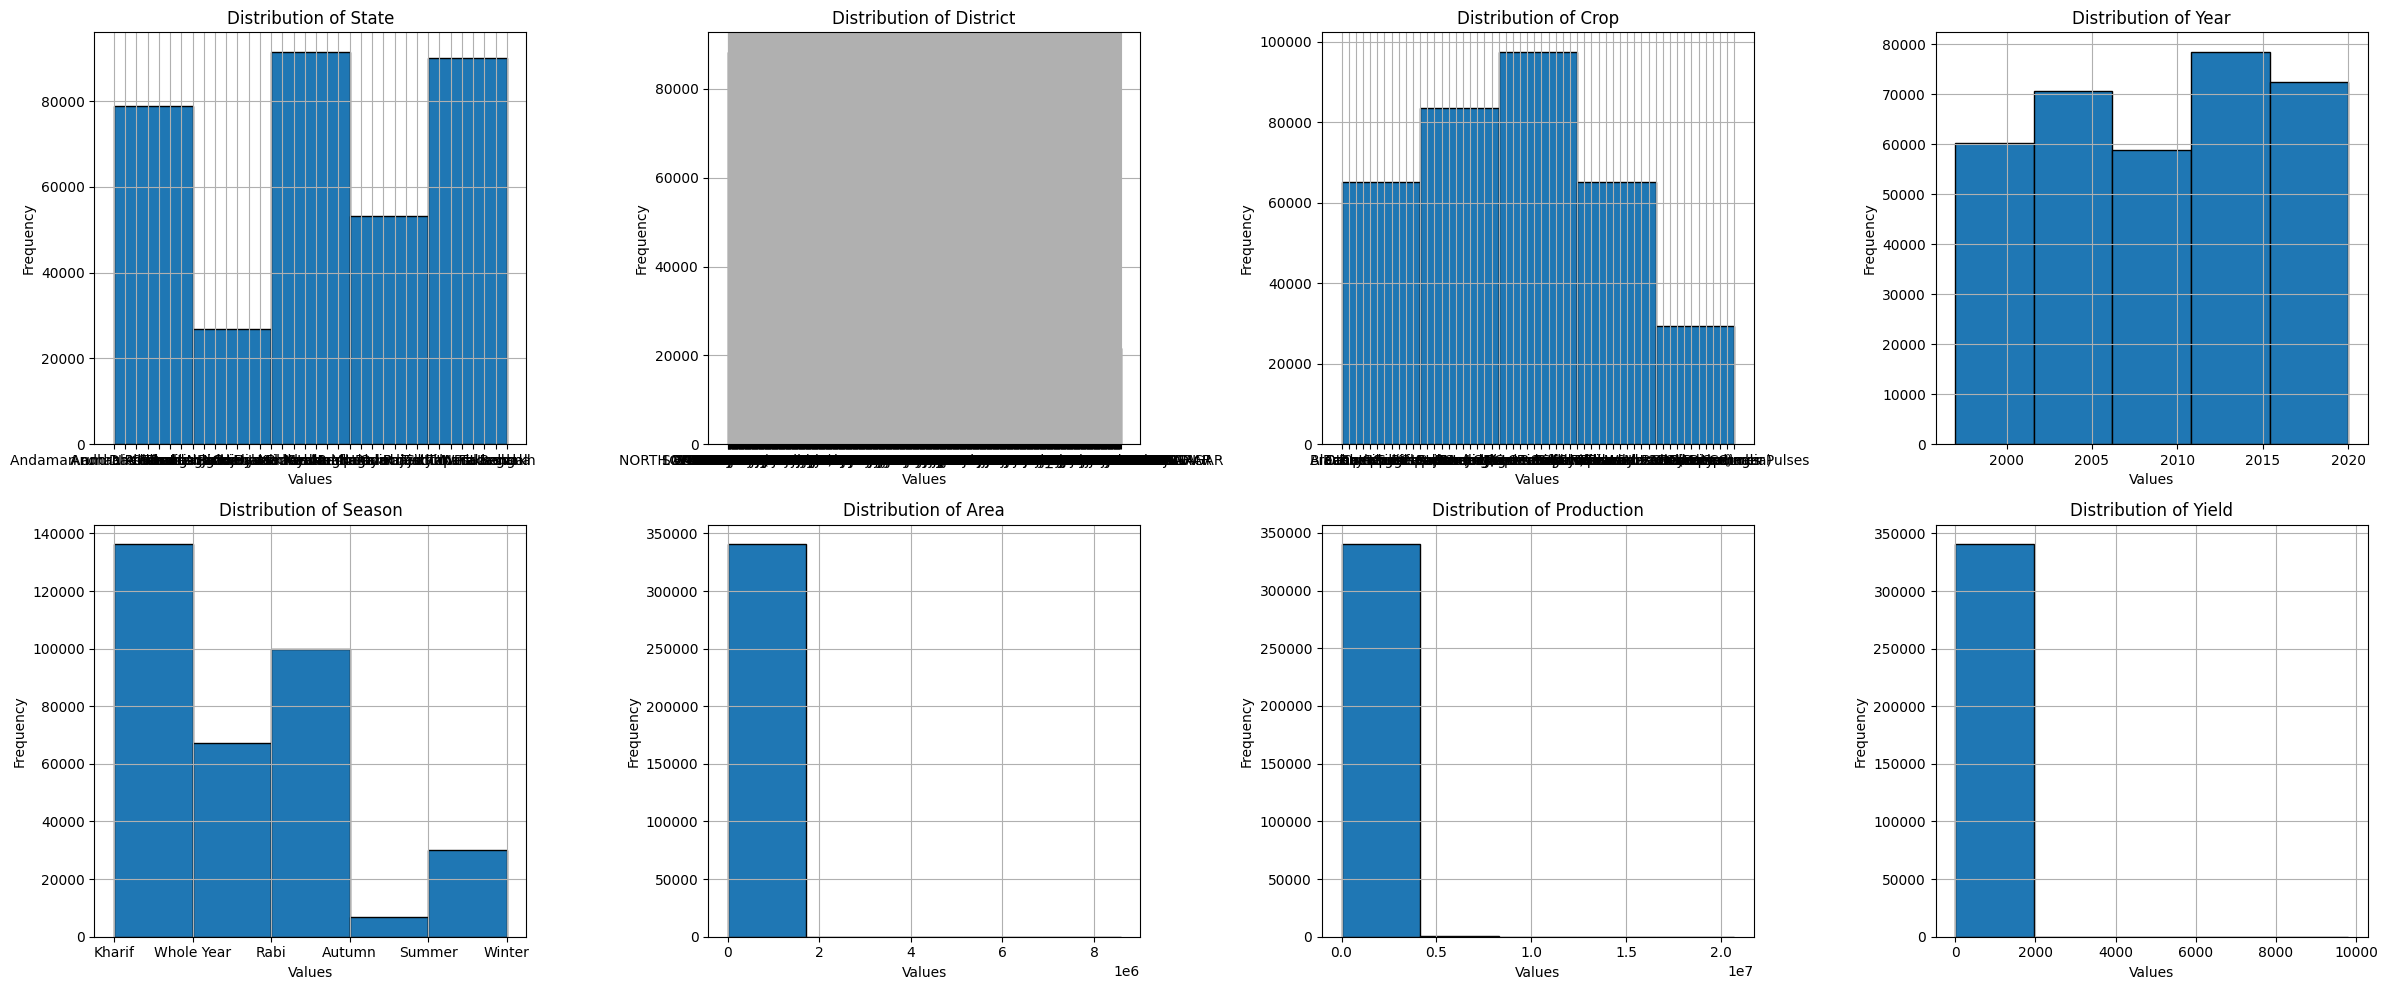

In [24]:
fig, axes = plt.subplots(2, 4, figsize=(24, 10))

for i, sutun in enumerate(df.columns[:8]): 
    ax = axes[i // 4, i % 4]  
    df[sutun].hist(ax=ax, bins=5, edgecolor='black')
    ax.set_title(f'Distribution of {sutun}')
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()
#There is an extreme right skewness, particularly in area, production, and yield.

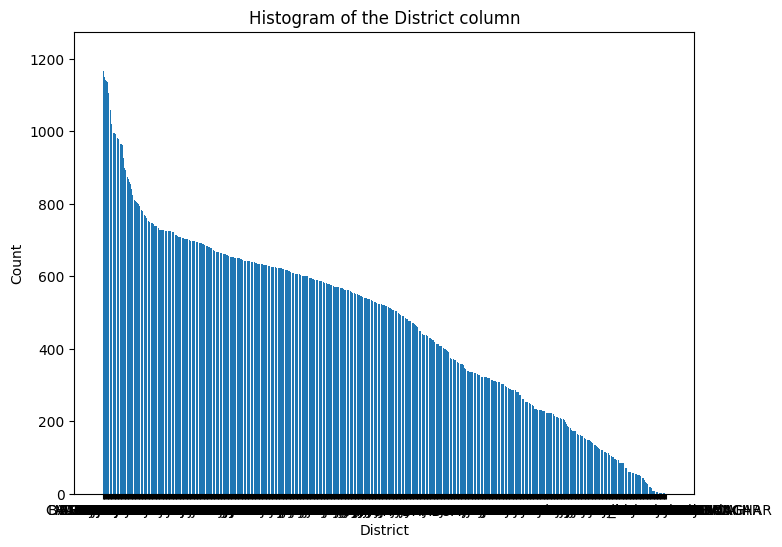

In [25]:
district_counts = df['District'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(district_counts.index, district_counts.values)
plt.xlabel('District')
plt.ylabel('Count')
plt.title('Histogram of the District column')
plt.show()

In [26]:
#I applied a logarithmic transformation to Production and Area because they were extremely right-skewed.
#Since Yield has many values in the 0-1 range, applying a logarithmic transformation significantly distorts the feature.
df['Area'] = np.log1p(df['Area'])
df['Production'] = np.log1p(df['Production'])

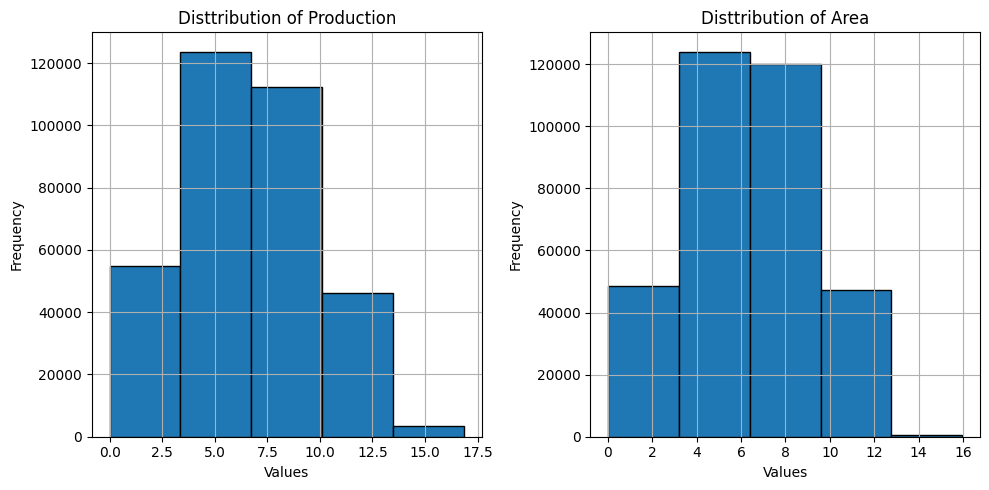

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, sutun in enumerate(['Production','Area']):
    ax = axes[i]  
    df[sutun].hist(ax=ax, bins=5, edgecolor='black')
    ax.set_title(f'Disttribution of {sutun}')
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [28]:
#Examine outliers for categorical data.

columns = ['District','Crop']
labels = {'District': 'diğer1', 'Crop': 'diğer2'}
for i in columns:
    alt_frekans_degeri = df[i].value_counts().quantile(0.05)
    frekanslar = df[i].value_counts()
    nadir_kategorikler = frekanslar[frekanslar<alt_frekans_degeri].index
    df[i] = df[i].replace(nadir_kategorikler,labels[i])
    
#I’m not applying it to Season because it contains only one categorical variable, which would make it meaningless (turning "Winter" into "Other" is very nonsensical).

In [29]:
#I conducted another outlier examination using the distance between quartiles.
print(df.shape)
liste = ['Area','Production','Year','Yield']
for i in liste:
    q1 = df[i].quantile(0.25)
    q3 = df[i].quantile(0.75)
    uzaklık = q3-q1
    alt_sınır = q1 - (1.5*uzaklık)
    üst_sınır = q3 + (1.5*uzaklık)
    df = df[(df[i]>= alt_sınır) &(df[i]<= üst_sınır)]
df.shape

(340414, 8)


(290076, 8)

In [30]:
scaler = StandardScaler()
df['Area'] = scaler.fit_transform(df[['Area']])
#Applying a standard scaler to Yield significantly distorts the feature. Therefore, I won’t scale it and will not use it for outlier examination going forward.

In [31]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination = 0.05)
columns = ['Production','Area']
df_1 = df[columns]
iso.fit(df_1)
df['outliers_skor'] = iso.predict(df_1)
df = df[df['outliers_skor'] != -1]
df = df.drop('outliers_skor',axis = 1)
df.shape

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


(275573, 8)

In [32]:
p = df[['Production','Area']]
kmeans = KMeans(n_clusters=2, n_init=10,random_state = 0)
kmeans.fit(p)
distances = np.min(np.linalg.norm(p.values[:,np.newaxis] - kmeans.cluster_centers_,axis = 2),axis = 1)
threshold = np.percentile(distances,95) 
df = df[distances <= threshold]
df.shape

(261992, 8)

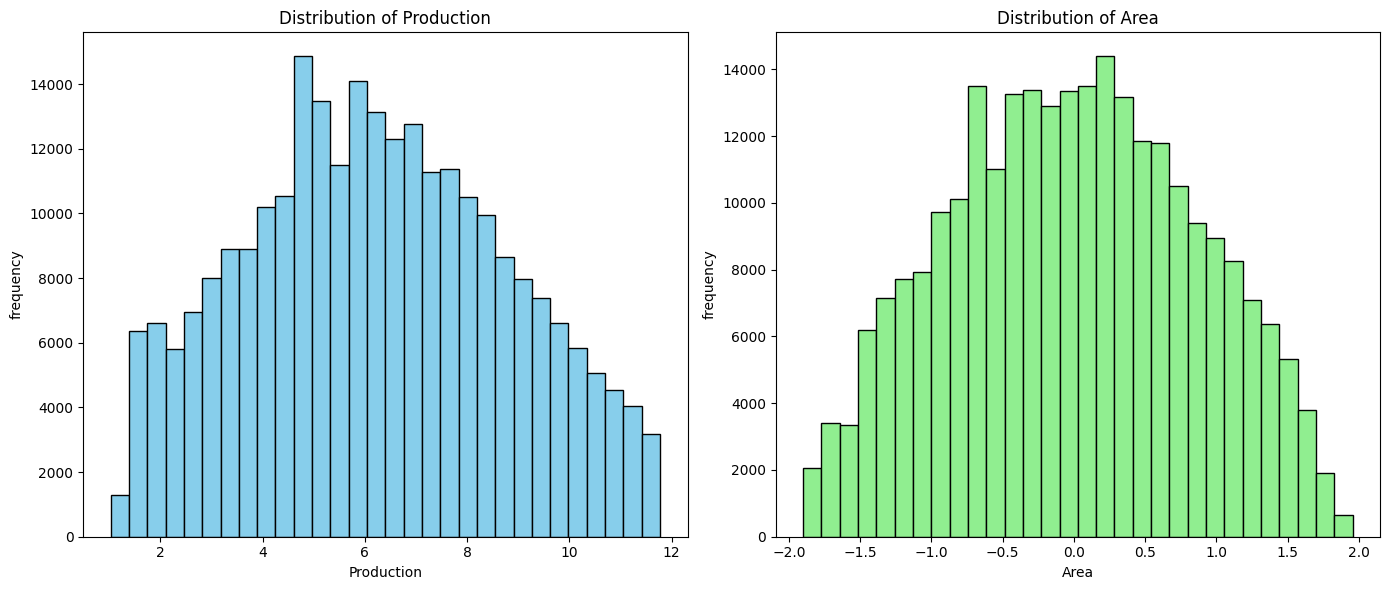

In [33]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(df['Production'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Production')
plt.xlabel('Production')
plt.ylabel('frequency')

plt.subplot(1, 2, 2)
plt.hist(df['Area'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of Area')
plt.xlabel('Area')
plt.ylabel('frequency')

plt.tight_layout()
plt.show()

In [34]:
#Since there is a strong relationship between State and District, and District has a higher relationship with Production, I am removing the State column.
#I am removing Year because its relationship with Production is very low (0.003).
#Since I can already calculate Yield from the given Production and Area values, including it from external sources might lead to inaccurate predictions by the model.
df = df.drop(['State','Year','Yield'],axis = 1)
df.head()

,District,Crop,Season,Area,Production
0,NICOBARS,Arecanut,Kharif,0.239973,7.631432
1,NICOBARS,Arecanut,Whole Year,0.241102,7.642044
2,NICOBARS,Arecanut,Whole Year,0.241946,7.330405
3,NORTH AND MIDDLE ANDAMAN,Arecanut,Kharif,0.560777,8.564077
4,SOUTH ANDAMANS,Arecanut,Whole Year,0.561348,8.569406


In [35]:
df = pd.get_dummies(df,columns =['District','Season','Crop'],drop_first = True)
df.head()

,Area,Production,District_24 PARAGANAS SOUTH,District_ADILABAD,District_AGAR MALWA,District_AGRA,District_AHMADABAD,District_AHMEDNAGAR,District_AIZAWL,District_AJMER,...,Crop_Sugarcane,Crop_Sunflower,Crop_Sweet potato,Crop_Tapioca,Crop_Tobacco,Crop_Turmeric,Crop_Urad,Crop_Wheat,Crop_diğer2,Crop_other oilseeds
0,0.239973,7.631432,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.241102,7.642044,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.241946,7.330405,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.560777,8.564077,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0.561348,8.569406,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [36]:
#To correct the true/false values, I extracted Area and Production, converted the data to integers, and then added them back.
a = df['Production']
b = df['Area']
df = df.drop(['Production','Area'],axis = 1)
df = df.astype(int)
df['Area'] = b
df['Production'] = a
df.head()

,District_24 PARAGANAS SOUTH,District_ADILABAD,District_AGAR MALWA,District_AGRA,District_AHMADABAD,District_AHMEDNAGAR,District_AIZAWL,District_AJMER,District_AKOLA,District_ALAPPUZHA,...,Crop_Sweet potato,Crop_Tapioca,Crop_Tobacco,Crop_Turmeric,Crop_Urad,Crop_Wheat,Crop_diğer2,Crop_other oilseeds,Area,Production
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.239973,7.631432
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.241102,7.642044
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.241946,7.330405
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.560777,8.564077
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.561348,8.569406


In [37]:
x = df.drop('Production',axis = 1)
y = df['Production']
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size = 0.8,random_state = 17)

In [38]:
import lightgbm as lgbm
model = lgbm.LGBMRegressor(boosting_type = 'gbdt',num_leaves = 100,learning_rate = 0.5,n_estimators =200,random_state = 33)
model.fit(x_train,y_train,eval_set = [(x_test,y_test)],eval_metric = 'l2')
print('Test score: ',model.score(x_test,y_test))
print('Train score: ',model.score(x_train,y_train))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1757
[LightGBM] [Info] Number of data points in the train set: 209593, number of used features: 752
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.223151
Test score:  0.9676549760586103
Train score:  0.9735614123124052


In [39]:
y_pred = model.predict(x_test)
artık = y_test - y_pred
print('The mean absolute difference between the predictions and the actual values: ',mean_absolute_error(y_test,y_pred))
print('The mean of the squared differences between the predictions and the actual values: ',np.sqrt(mean_squared_error(y_test,y_pred)))
print('Explained variance: ',explained_variance_score(y_test,y_pred))

The mean absolute difference between the predictions and the actual values:  0.33457070533326216
The mean of the squared differences between the predictions and the actual values:  0.4590749046796017
Explained variance:  0.9676557821628881


In [40]:
print('The lowest Production value: ',y_test.min())
print('The highest Production value: ',y_test.max())

The lowest Production value:  1.0296194171811583
The highest Production value:  11.767846714178527


In [41]:
print('The variance of the predicted values: ',np.var(y_pred))
print('The variance of the actual values: ',y_test.var())

The variance of the predicted values:  6.3084280879945185
The variance of the actual values:  6.51580257241835


In [42]:
pozitif_artık = artık[artık>0]
negatif_artık = artık[artık<0]
print('The total of positive residuals: ',np.sum(pozitif_artık))
print('The total of negative residuals: ',np.sum(negatif_artık))
#9406
#-9571

The total of positive residuals:  8705.541358343164
The total of negative residuals:  -8825.629030414442


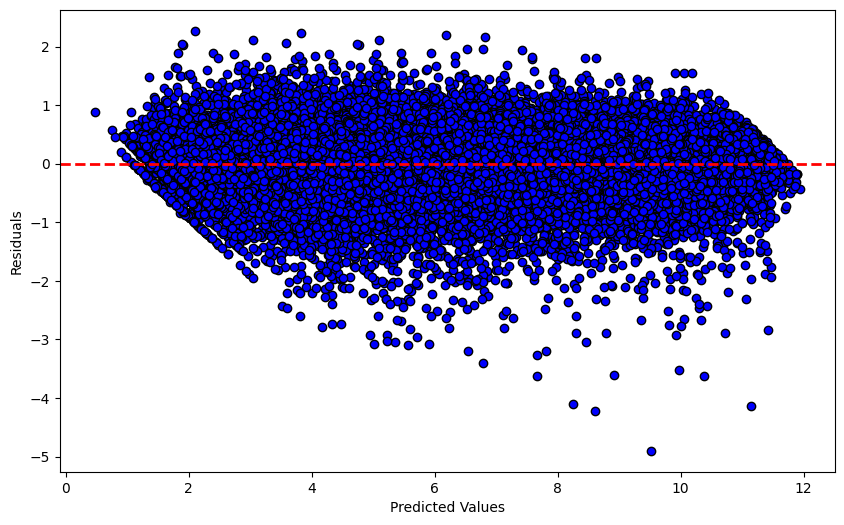

In [43]:
plt.figure(figsize = (10,6))
plt.scatter(y_pred,artık,color = 'blue',edgecolor = 'k')
plt.axhline(0,color = 'red',linestyle = '--',linewidth = 2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [44]:
#Finding the optimal train-test split
import lightgbm as lgbm
from sklearn.model_selection import KFold
x = np.array(x)
y = np.array(y)
kf = KFold(n_splits = 5,shuffle = True,random_state = 0)

for train,test in kf.split(x):
    x_train,x_test = x[train],x[test]
    y_train,y_test = y[train],y[test]
    model = lgbm.LGBMRegressor(boosting_type = 'gbdt',num_leaves = 50,learning_rate = 0.21,early_stopping_rounds=10,n_estimators =100,random_state = 33)
    model.fit(x_train,y_train,eval_set = [(x_test,y_test)],eval_metric = 'l2')
    print('Test Score: ',model.score(x_test,y_test))
    print('Train Score: ',model.score(x_train,y_train))
    y_pred = model.predict(x_test)
    print(mean_absolute_error(y_test,y_pred))
    print(mean_squared_error(y_test,y_pred),'\n')

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1757
[LightGBM] [Info] Number of data points in the train set: 209593, number of used features: 752
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Start training from score 6.220363
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.262381
Test Score:  0.9597639514614101
Train Score:  0.961534778962397
0.38251110239986386
0.26238061464572543 

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM]

In [45]:
#Tuning
#I found the optimal parameters with the code above, but to save time, I will continue directly with the optimal parameters.
#from sklearn.model_selection import GridSearchCV
#import lightgbm as lgbm

#modeller = {
#    'LGBM_Regressor': {
#        'model': lgbm.LGBMRegressor(),
#        'params': {
#            'n_estimators': [20, 40, 70, 100, 150, 200],
#            'learning_rate': [0.1, 0.2, 0.3, 0.5],
#            'num_leaves': [20, 40, 60, 80, 100],
#            'max_depth': [50, 100, 200, 300]
#        }
#    }
#}
#
#scores = []
#for model_name, mp in modeller.items():
#    print(f"Training {model_name}...")
#    grid_search = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=True)
#    grid_search.fit(x_train, y_train)
#    
#    results = grid_search.cv_results_
#    for mean_test_score, mean_train_score, params in zip(results['mean_test_score'], results['mean_train_score'], results['params']):
#        scores.append({
#            'model': model_name,
#            'mean_test_score': mean_test_score,
#            'mean_train_score': mean_train_score,
#            'params': params
#        })

#for score in scores:
#    print(f"Model: {score['model']}")
#    print(f"Mean Test Score: {score['mean_test_score']:.4f}")
#    print(f"Mean Train Score: {score['mean_train_score']:.4f}")
#    print(f"Parameters: {score['params']}")
#    print('-' * 60)

In [46]:
model = lgbm.LGBMRegressor(boosting_type = 'gbdt',num_leaves = 50,learning_rate = 0.21,early_stopping_rounds=10,n_estimators =100,max_depth = 30,random_state = 33)
model.fit(x_train,y_train,eval_set = [(x_test,y_test)],eval_metric = 'l2')
print('Test score: ',model.score(x_test,y_test))
print('Train score: ',model.score(x_train,y_train))

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1757
[LightGBM] [Info] Number of data points in the train set: 209594, number of used features: 752
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Start training from score 6.220602
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.256429
Test score:  0.9606406478743541
Train score:  0.9613348573987819


In [47]:
#I predicted the production of a field based on its district, season, crop, and area
def tek_tahmin(model, district, season, area, crop):
    input_data = pd.DataFrame({
        'District': [district],
        'Season': [season],
        'Area': [area]
    })
    
    input_data = pd.get_dummies(input_data, columns=['District', 'Season'], drop_first=True)

    model_features = model.booster_.feature_name()

    missing_cols = list(set(model_features) - set(input_data.columns))
    missing_data = pd.DataFrame(0, index=input_data.index, columns=missing_cols)
    input_data = pd.concat([input_data, missing_data], axis=1)

    input_data = input_data[model_features]

    crops = [col for col in model_features if 'Crop_' in col]
    for col in crops:
        input_data[col] = 1 if col == f'Crop_{crop}' else 0

    prediction = model.predict(input_data)

    return prediction[0]

district = 'NICOBARS'
season = 'Whole Year'
area = 100
area = np.log1p(area)
crop = 'Onion'

tahmin_sonucu = tek_tahmin(model, district, season, area, crop)

print(f"Tahmin edilen üretim: {np.exp(tahmin_sonucu)-1}")

Tahmin edilen üretim: 521.65391902922
